# Prior-Data Fitted Networks

Bayesian methods enable the explicit specification of prior knowledge and accurately capture model uncertainty. However, traditional deep learning methods fall short in integrating priors and quantifying uncertainty effectively. Regularization techniques—such as model architecture adjustments, data augmentation, and weight decay—are fundamentally designed to incorporate priors indirectly by promoting generalization beyond the training data. For instance, a weight decay penalty implicitly suggests preferences within the hypothesis space from which the model learns.

Our goal is to enable models to more directly consider the priors that inform the data generation process. This objective led to the development of Prior-Data Fitted Networks (PFNs) by Müller et al. (2021). PFNs leverage synthetically generated data, derived from specified priors, to train models. These networks aim to predict the conditional distribution of the output given the features and the broader dataset. In mathematical terms, we often employ Bayes' Theorem to estimate the **posterior distribution** of model parameters given a dataset, \(\mathcal{D}\), as follows:

$$
P(\theta \mid \mathcal{D}) \propto P(\mathcal{D} \mid \theta)P(\theta)
$$

With the posterior distribution, our aim shifts to predicting outcomes, or the **Posterior Predictive Distribution (PPD)**:

$$
P(y \mid x, \mathcal{D}) = \int_{y} P(y \mid x, \theta )P(\theta \mid \mathcal{D})
$$

PFNs employ large-scale machine learning techniques to approximate the PPD, enabling predictions about the distribution of $y$ for a new data point $x$, given a dataset $\mathcal{D}$.

"*The primary requirement for PFNs is the capability to sample from a prior distribution over supervised learning tasks. PFNs are essentially learning to approximate Bayesian inference.*",  Muller et al. 2021

## Applications

Prior data proves most valuable in contexts where large datasets are not available. While abundant data can inherently define its own priors, understanding priors becomes crucial with smaller, high-quality datasets. Bayesian inference, facilitated by PFNs, excels in these scenarios by leveraging prior knowledge.

PFNs are particularly suited for machine learning tasks involving small, high-quality datasets, often dealing with datasets of up to 1000 points.

## Content

In this tutorial, following the work of Müller et al. (2021) and Hollmann et al. (2023), we will explore how neural networks can approximate PPD for various priors. We will cover:

1. Defining a prior for ridge regression.
2. Creating a dataset loader for endless synthetic data generation from the prior.
3. Developing a transformer model to approximate PPD.
4. Formulating a loss function specific to ridge regression.
5. Evaluating the output quality.

### Note

This tutorial has been created based on my interpretation of the paper and the GitHub repositories linked in the respective papers.


References:
- [Müller et al. (2021)](https://arxiv.org/abs/2112.10510) "Transformers Can Do Bayesian Inference."
- [Hollmann et al. (2023)](https://arxiv.org/abs/2207.01848) "TabPFN: A Transformer That Solves Small Tabular Classification Problems in a Second."


In [1]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
import math
import pathlib
import random
import sklearn.linear_model
import torch
import torch.nn as nn
from torch.nn.modules.transformer import MultiheadAttention
from torch.optim.lr_scheduler import LambdaLR

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", device)
else:
    device = torch.device("cpu")
    print("No GPU -> using CPU:", device)

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

Using GPU: cuda


## Data Generating Prior

For a Prior-Data Fitted Network (PFN), it's crucial to generate synthetic data based on well-defined priors. In this tutorial, we'll explore a PFN designed to approximate the Posterior Predictive Distribution (PPD), where the model parameters $\theta$ are drawn from a normal distribution centered around the origin.

### Ridge Regression Prior

The $L2$ penalty acts to pull model weights towards the origin, favoring weights that are centrally concentrated within a Gaussian distribution. This preference aligns with the prior belief that optimal weights are likely to be small and clustered around zero, which reflects a common regularization strategy to prevent overfitting by penalizing large weights.

Thus, our prior is a linear regression using wieghts $\theta$ which are distributed according to the Normal distribution centered around origin.

$$
y = \mathcal{N}(x^{T}w, a^2I), \text{and }w \sim \mathcal{N}(0, b^2I)
$$

In the code below, we represent $a$ by `variance_weights` and $b$ by `output_noise`. 

Our dataset consists of `num_datasets` datasets where each consists of `num_points_in_each_dataset` points. 
Thus, `x` has. the dimension `num_datasets  x num_points_in_each_dataset x num_features`

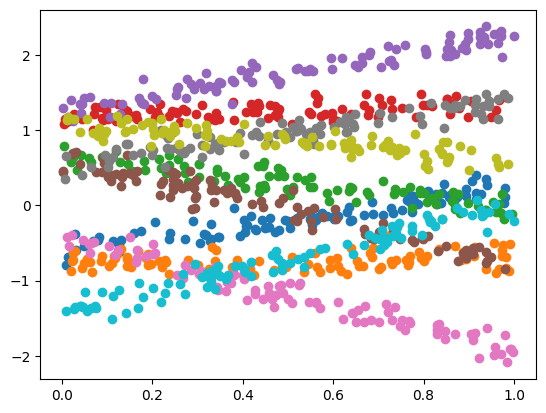

In [2]:
num_datasets = 10
num_points_in_each_dataset = 100
hyperparameters = {
    'variance_weights': 1.0,
    'output_noise': 0.1,
}
num_features = 1

def get_ridge_regression_prior(num_datasets, num_features, num_points_in_each_dataset, hyperparameters, bias_term=True):
    """
    Args:
        num_datasets: number of datasets in each batch
        num_features: number of features to use
        num_points_in_each_dataset: number of points in each dataset
        hyperparameters: hyperparameters to define the prior
        bias_term: Whether to use the bias term in the regression
    
    Returns:
        x, y
    """

    # Sample weights for ridge regression
    ws = torch.distributions.Normal(torch.zeros(num_features + 1 * bias_term), hyperparameters['variance_weights']).sample((num_datasets,)) # a tensor of shape (num_datasets, 1)

    # Sample xs
    xs_ = xs = torch.rand(num_datasets, num_points_in_each_dataset, num_features)
    if bias_term:
        xs_ = torch.cat([xs, torch.ones(num_datasets, num_points_in_each_dataset, 1)], 2)
    
    
    # Compute the conditional expectation for each x
    ys = torch.distributions.Normal(torch.einsum('nmf, nf -> nm', xs_, ws), hyperparameters['output_noise']).sample()
    
    return xs, ys

xs, ys = get_ridge_regression_prior(num_datasets, num_features, num_points_in_each_dataset, hyperparameters)
for dataset_index in range(num_datasets):
    plt.scatter(xs[dataset_index,:,0].numpy(), ys[dataset_index].numpy())

## Dataloader

To train a PFN, we will need a dataloader that can continuously generate the synthetic dataset.

An important consideration in the data generation process is the size of each training set, denoted as `trainset_size`. In the context of PFNs, it's beneficial to expose the network to larger datasets, as they typically contain more information and offer a better approximation of the true data distribution. To ensure that our PFN frequently encounters larger datasets, we'll implement a function named `_sample_trainset_size`.

In [3]:
class PriorDataLoader(object):
    def __init__(self, get_prior_data_fn, batch_size, num_points_in_each_dataset):
        self.batch_size = batch_size
        self.num_points_in_each_dataset = num_points_in_each_dataset
        self.get_prior_data_fn = get_prior_data_fn
        
        self.epoch = 0
        
    def get_batch(self, train = True, batch_size=None):
        """
        Returns:
            xs, ys, trainset_size
        """
        self.epoch += train
        bs = batch_size if batch_size else self.batch_size
        return self.get_prior_data_fn(bs, self.num_points_in_each_dataset), self._sample_trainset_size()

    def _sample_trainset_size(self):
        # samples a number between 1 and n-1 with higher weights to larger numbers
        # Appendix E.1 of Muller et al. (2021)
        min_samples = 1
        max_samples = self.num_points_in_each_dataset - 1
        
        sampling_weights = [1 / (max_samples - min_samples - i) for i in range(max_samples - min_samples)]
        return random.choices(range(min_samples, max_samples), sampling_weights)[0]

In [4]:
get_prior_data_fn = lambda x, y: get_ridge_regression_prior(x, num_features, y, hyperparameters)
dl = PriorDataLoader(get_prior_data_fn, 10, 100)
for _ in range(2):
    (x,y), sz = dl.get_batch()
    

## Regression as Classification

To establish a unified framework, the authors reformulate the regression task as a classification task. This transformation is achieved by categorizing the output into several predefined classes based on the distribution of y-values in the prior.

The following steps outline this process:

1. `get_bucket_limits`: Create buckets for y-values such that each bucket contains an approximately equal number of observations (y's). This process will result in narrower buckets in regions where y-values are densely packed.
2. `y_to_bucket_idx`: Classify the y-values into their respective buckets or classes.


In [5]:
_, ys = get_ridge_regression_prior(100000, num_features, 100, hyperparameters)

def get_bucket_limts(num_outputs, ys):
    """
    Creates buckets based on the values in y. 
    
    Args:
        num_outputs: number of buckets to create
        ys: values of y in the prior
    
    Returns:
        bucket_limits: An array containing the borders for each bucket. 
    """
    ys  = ys.flatten()

    if len(ys) % num_outputs:
        ys = ys[:-(len(ys) % num_outputs)]

    ys_per_bucket = len(ys) // num_outputs
    full_range = (ys.min(), ys.max())

    ys_sorted, _ = ys.sort(0)

    bucket_limits = (ys_sorted[ys_per_bucket-1::ys_per_bucket][:-1] + ys_sorted[ys_per_bucket::ys_per_bucket]) / 2
    bucket_limits = torch.cat([full_range[0].unsqueeze(0), bucket_limits, full_range[1].unsqueeze(0)], dim=0)
    return bucket_limits

bl = get_bucket_limts(100, ys)
print(bl)
print(bl.shape)

tensor([-6.7185e+00, -2.7366e+00, -2.3934e+00, -2.1830e+00, -2.0245e+00,
        -1.8970e+00, -1.7889e+00, -1.6951e+00, -1.6110e+00, -1.5344e+00,
        -1.4640e+00, -1.3996e+00, -1.3395e+00, -1.2834e+00, -1.2304e+00,
        -1.1799e+00, -1.1316e+00, -1.0854e+00, -1.0409e+00, -9.9815e-01,
        -9.5664e-01, -9.1643e-01, -8.7729e-01, -8.3922e-01, -8.0197e-01,
        -7.6565e-01, -7.2983e-01, -6.9487e-01, -6.6053e-01, -6.2680e-01,
        -5.9383e-01, -5.6109e-01, -5.2901e-01, -4.9753e-01, -4.6642e-01,
        -4.3564e-01, -4.0532e-01, -3.7517e-01, -3.4560e-01, -3.1611e-01,
        -2.8669e-01, -2.5758e-01, -2.2871e-01, -2.0003e-01, -1.7123e-01,
        -1.4255e-01, -1.1413e-01, -8.5857e-02, -5.7334e-02, -2.8981e-02,
        -5.7322e-04,  2.7888e-02,  5.6166e-02,  8.4507e-02,  1.1292e-01,
         1.4147e-01,  1.7019e-01,  1.9876e-01,  2.2765e-01,  2.5672e-01,
         2.8590e-01,  3.1532e-01,  3.4489e-01,  3.7487e-01,  4.0506e-01,
         4.3556e-01,  4.6660e-01,  4.9809e-01,  5.2

In [6]:
def y_to_bucket_idx(ys, bl):
    """
    Maps the value of y to the corresponding bucket in `bl`
    
    Args:
        ys: value of y to be mapped into a bucket in bl
        bl: bucket limits specifiying the borders of buckets
    
    Returns:
        values of corresponding bucket number for y in bl
    """
    target_sample = torch.searchsorted(bl, ys) - 1
    target_sample[ys <= bl[0]] = 0
    target_sample[ys >= bl[-1]] = len(bl) - 1 - 1
    return target_sample

target = y_to_bucket_idx(ys, bl)
print(target, ys.shape, target.shape, target.min(), target.max())

tensor([[57, 31, 53,  ..., 65, 57, 66],
        [98, 96, 98,  ..., 98, 98, 93],
        [70, 73, 68,  ..., 75, 73, 72],
        ...,
        [85, 86, 79,  ..., 82, 88, 87],
        [66, 89, 74,  ..., 79, 76, 68],
        [71, 64, 58,  ..., 69, 50, 54]]) torch.Size([100000, 100]) torch.Size([100000, 100]) tensor(0) tensor(99)


## Transformer model

Here, we will define a transformer model to process the prior datasets. 

In [7]:
class Encoder(nn.Module):
    """Typical self attention module in transformer"""
    def __init__(self, d_model, n_heads, n_hidden, dropout=0.1):
        super().__init__()
        self.self_attn = MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.out = nn.Sequential(
            nn.Linear(d_model, n_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(n_hidden, d_model),
        )
        
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
    def forward(self, src, trainset_size):
        src_left, src_right = src[:, :trainset_size], src[:, trainset_size:]
        x_left = self.self_attn(src_left, src_left, src_left)[0] # all train points to each other
        x_right = self.self_attn(src_right, src_left, src_left)[0] # test points attend to train points
        x = torch.cat([x_left, x_right], dim=1)
        x = self.norm1(src + self.dropout(x))
        return self.norm2(self.dropout(self.out(x)) + x)


class Transformer(nn.Module):
    def __init__(self, num_features, n_out, n_layers=2, d_model=512, n_heads=4, n_hidden=1024, dropout=0.0, normalize=lambda x:x):
        super().__init__()
        
        self.x_encoder = nn.Linear(num_features, d_model)
        self.y_encoder = nn.Linear(1, d_model)
        
        self.model = nn.ModuleList(
            [Encoder(d_model, n_heads, n_hidden, dropout) for _ in range(n_layers)]
        )
        
        self.out = nn.Sequential(
            nn.Linear(d_model, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_out)
        )
                
        self.normalize = normalize
        self.init_weights()
        
    def forward(self, x, y, trainset_size):
        """
        Args:
            x: num_datasets x number_of_points x num_features
            y: num_datasets x number_of_points
            trainset_size: int specifying the number of points to use as training dataset size
        
        Returns:
            outputs for each x
        """
        x_src = self.x_encoder(self.normalize(x))
        y_src = self.y_encoder(y)
        
        src = torch.cat([x_src[:, :trainset_size] + y_src[:, :trainset_size], x_src[:, trainset_size:]], dim=1)
        for encoder in self.model:
            src = encoder(src, trainset_size)

        return self.out(src)
    
    def init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

In [8]:
model = Transformer(1, 100, normalize=lambda x: (x-0.5)/math.sqrt(1/12))
get_prior_data_fn = lambda x, y: get_ridge_regression_prior(x, num_features, y, hyperparameters)
dl = PriorDataLoader(get_prior_data_fn, 1, 4)

(xs, ys), trainset_size = dl.get_batch(False)
print(trainset_size)
pred_y = model(xs, ys.unsqueeze(-1), trainset_size)

2


## Loss function

The authors model continuous distributions using discretized continuous distributions, which they refer to as the 'Riemann Distribution.' The Probability Density Functions (PDFs) of this distribution resemble bar plots. The boundaries are chosen so that each bucket has the same probability in the prior data, denoted as $p(y \in b) = 1/{\mathbf{B}}$, where $\mathbf{B}$ represents the number of buckets. This approach, of course, assumes a fixed support; therefore, the authors modify it by adjoining half-normals towards each end.

<img src='images/bar-dist.png' width=500px>

Thus, if $b$ is the bucket such that it has the width denoted by $\text{width}_b$, probability of $P(Y=y \mid y \in b) = 1/\text{width}_b$

$$
P(Y = y) = P(y \in b) \times P(Y = y| y \in b)
$$

$$
P(Y = y) =  1 / \text{width}_b \times P(y \in b)
$$



In [9]:
def get_halfnormal_with_p_weight_before(range_max, p=0.5):
    """
    Constructs a half normal distribution. 
    Args:
        range_max: used for scaling the half normal so that `p` portion of the half normal lies within range_max
        p: Cumulative probability under half normal

    Returns:
        half normal distribution
    """
    s = range_max / torch.distributions.HalfNormal(torch.tensor(1.)).icdf(torch.tensor(p))
    return torch.distributions.HalfNormal(s)

def compute_bar_distribution_loss(logits, target_y, bucket_limits, label_smoothing=0.0):
    """
    Implements Reimann distribution for logits. See Appendix E of Muller et al. 2021.
    
    Args:
        logits: num_datasets  x num_points_in_each_dataset x num_outputs_for_classification
        target_y: target class for each point 
        bucket_limits: border limits for each class
        label_smoothing: constant to define the amount of label smoothing to be used.
    
    Returns:
        loss: scalar value
    
    """
    target_y_idx = y_to_bucket_idx(target_y, bucket_limits)

    bucket_widths = bucket_limits[1:] - bucket_limits[:-1]
    bucket_log_probs = torch.log_softmax(logits, -1)
    scaled_bucket_log_probs = bucket_log_probs - torch.log(bucket_widths) # Refer to the equation above
    log_probs = scaled_bucket_log_probs.gather(-1, target_y_idx[..., None]).squeeze(-1)
    
    # full support distribution correction using half normals
    side_normals = (
        get_halfnormal_with_p_weight_before(bucket_widths[0]),
        get_halfnormal_with_p_weight_before(bucket_widths[-1])
    )
    # Correction for the bucket in the starting
    first_bucket = target_y_idx == 0
    log_probs[first_bucket] += side_normals[0].log_prob((bucket_limits[1] - target_y[first_bucket])).clamp(min=1e-8) + torch.log(bucket_widths[0])

    # Correction for the bucket at the end
    last_bucket = target_y_idx == len(bucket_widths) - 1
    log_probs[last_bucket] += side_normals[1].log_prob((target_y[last_bucket] - bucket_limits[-2])).clamp(min=1e-8) + torch.log(bucket_widths[-1])
    
    nll_loss = -log_probs
    smooth_loss = -scaled_bucket_log_probs.mean(dim=-1)
    
    loss = (1-label_smoothing) * nll_loss + label_smoothing * smooth_loss
    return loss.mean()

In [10]:
logits = pred_y[:, trainset_size:]
target_y = ys[:, trainset_size:].clone().view(*logits.shape[:-1])

compute_bar_distribution_loss(logits.cpu(), target_y.cpu(), bl.cpu())

tensor(2.5983, grad_fn=<MeanBackward0>)

## Train the transformer

Here we will use the standard setup required to train transformers.

In [11]:
# copied from huggingface
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1):
    """ Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return LambdaLR(optimizer, lr_lambda, last_epoch)

#### Note
There are two important factors that impact the performance of the models: **input normalization** and **dropout**. Having a non-zero value for dropout can result in a PPD (Posterior Predictive Distribution) that is not smooth, while the absence of a normalization scheme may lead to poor performance due to inconsistency in the inputs.

In [12]:
# Parameters related to prior data
num_points_in_each_dataset = 100
hyperparameters = {
    'variance_weights': 1.0,
    'output_noise': 0.1,
}
bias_term = True
num_features = 1
num_outputs = 100
max_num_datasets = 16


# Reimannian distribution
_, ys = get_ridge_regression_prior(100000, num_features, num_points_in_each_dataset, hyperparameters, bias_term)
bucket_limits = get_bucket_limts(num_outputs, ys)

# training data
get_prior_data_fn = lambda x, y: get_ridge_regression_prior(x, num_features, y, hyperparameters, bias_term)
dl = PriorDataLoader(get_prior_data_fn, batch_size=max_num_datasets, num_points_in_each_dataset=num_points_in_each_dataset)

# Models
uniform_normalize = lambda x: (x-0.5)/math.sqrt(1/12)
model = Transformer(num_features, n_out=num_outputs, d_model=256, n_layers=4, n_hidden=512, n_heads=4, normalize=uniform_normalize)

# Learning
epochs = 40
steps_per_epoch = 100
warmup_epochs = epochs // 4
validate_epoch = 10
lr = 0.001

model.to(device)
bucket_limits = bucket_limits.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_epochs, epochs)

# test data
(test_xs, test_ys), test_trainset_size = dl.get_batch(False, 64)
test_xs, test_ys = test_xs.to(device), test_ys.to(device)

for step in range(epochs * steps_per_epoch + 1):
    (xs, ys), trainset_size = dl.get_batch()
    xs, ys = xs.to(device), ys.to(device)
    pred_y = model(xs, ys.unsqueeze(-1), trainset_size)

    logits = pred_y[:, trainset_size:]
    target_y = ys[:, trainset_size:].clone().view(*logits.shape[:-1])
    
    loss = compute_bar_distribution_loss(logits, target_y, bucket_limits)
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
    optimizer.step()
    scheduler.step()
    
    if step % (validate_epoch * steps_per_epoch) == 0:
        with torch.no_grad():
            pred_test_y = model(test_xs, test_ys.unsqueeze(-1), test_trainset_size)

            logits = pred_test_y[:, test_trainset_size:]
            target_test_y = test_ys[:, test_trainset_size:].clone().view(*logits.shape[:-1])

            val_loss = compute_bar_distribution_loss(logits, target_test_y, bucket_limits)

        print(f'@Step: {step}\tVal loss:{val_loss.item(): 0.5f}\t lr:{scheduler.get_last_lr()[0]: 0.6e}\t train_loss:{loss.item(): 0.5f}')

/home/mila/g/guptapra/.conda/envs/llmtime/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


@Step: 0	Val loss: 1.65764	 lr: 1.000000e-04	 train_loss: 1.66257
@Step: 1000	Val loss:-0.52416	 lr: 2.739052e-06	 train_loss:-0.52027
@Step: 2000	Val loss:-0.53749	 lr: 7.033683e-04	 train_loss:-0.47441
@Step: 3000	Val loss:-0.40496	 lr: 7.938926e-04	 train_loss:-0.66686
@Step: 4000	Val loss:-0.66951	 lr: 2.739052e-06	 train_loss:-0.72974


## Compute metrics and visualize

In [13]:
def compute_mean(logits, bucket_limits):
    """
    Computes mean from logits
    
    Args:
        logits: num_datasets  x num_points_in_each_dataset x num_outputs_for_classification
        bucket_limits: border limits for each class
    
    Returns:
        means
    """
    bucket_widths = bucket_limits[1:] - bucket_limits[:-1]
    bucket_means = bucket_limits[:-1] + bucket_widths / 2
    p = torch.softmax(logits, dim=-1)
    
    # full support correction through half normal (see Appendix E of Muller et al. 2021)
    side_normals = (
        get_halfnormal_with_p_weight_before(bucket_widths[0]),
        get_halfnormal_with_p_weight_before(bucket_widths[-1])
    )
    bucket_means[0] = -side_normals[0].mean + bucket_widths[1]
    bucket_means[-1] = side_normals[1].mean + bucket_widths[-2]
    
    return p @ bucket_means

def cdf(logits, left_prob, bucket_limits):
    """
    Computes quantile corresponding to left_prob
    
    Args:
        logits: num_datasets  x num_points_in_each_dataset x num_outputs_for_classification
        left_prob: probability of the output to be less than this value
        bucket_limits: border limits for each class
    
    Returns:
        points corresponding to left_prob
    
    """
    probs = torch.softmax(logits, -1)
    cumprobs = torch.cumsum(probs, -1)
    idx = torch.searchsorted(cumprobs, left_prob * torch.ones(*cumprobs.shape[:-1], 1)).squeeze(-1).clamp(0, cumprobs.shape[-1] - 1)
    cumprobs = torch.cat([torch.zeros(*cumprobs.shape[:-1], 1, device=logits.device), cumprobs], -1)
    
    rest_prob = left_prob - cumprobs.gather(-1, idx[..., None]).squeeze(-1)
    left_border = bucket_limits[idx]
    right_border = bucket_limits[idx+1]
    return left_border + (right_border - left_border) * rest_prob / probs.gather(-1, idx[..., None]).squeeze(-1)
    

def compute_quantile(logits, bucket_limits, center_prob = 0.682):
    """
    Computes +/- quantiles corresponding to cetner_prob.
    
    Args:
        logits: num_datasets  x num_points_in_each_dataset x num_outputs_for_classification
        bucket_limits: border limits for each class
        center_prob: Probability mass for the points to be in the middle of mean +/- quantile value
    
    Returns:
        left quantile, right quantile
    
    """
    # center_prob = 0.682 area under the normal function within 1 std
    side_prob = (1.0-center_prob)/2
    
    # compute the quantile corresp. to this side_prob and  1-side_prob
    return torch.stack([cdf(logits, side_prob, bucket_limits), cdf(logits, 1-side_prob, bucket_limits)], -1)
    

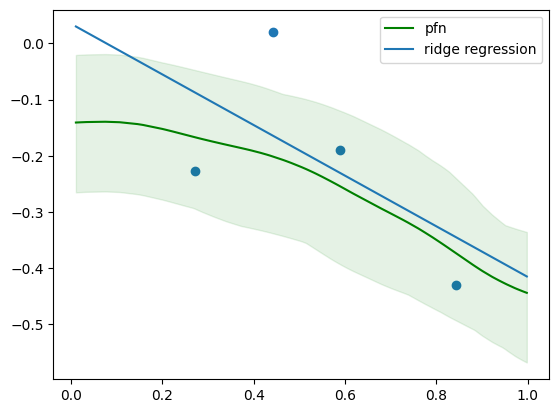

In [17]:
(xs, ys), num_training_points = dl.get_batch()

batch_index = 3
num_training_points = 4 # this is the trainset_size

xs_train = xs[batch_index, :num_training_points]
ys_train = ys[batch_index, :num_training_points]
xs_test = xs[batch_index, num_training_points:]

with torch.no_grad():
    logits = model(xs.to(device), ys.unsqueeze(-1).to(device), num_training_points)

# predicted means from a bar distribution
test_logits = logits[batch_index, num_training_points:].cpu()
pred_means = compute_mean(test_logits, bucket_limits.cpu())
pred_confs = compute_quantile(test_logits, bucket_limits.cpu())

# plot pfn
plt.scatter(xs_train[..., 0], ys_train)
order_test_x = xs_test[..., 0].argsort()
plt.plot(xs_test[order_test_x, 0], pred_means[order_test_x], color='green', label='pfn')
plt.fill_between(xs_test[order_test_x, 0], pred_confs[order_test_x, 0], pred_confs[order_test_x, 1], alpha=0.1, color='green')

ridge_model = sklearn.linear_model.Ridge(alpha=(hyperparameters['output_noise']/hyperparameters['variance_weights'])**2)
ridge_model.fit(xs_train, ys_train)
plt.plot(xs_test[order_test_x, 0], ridge_model.predict(xs_test[order_test_x]), label='ridge regression')
plt.legend()
# plt.plot();

### Visualizing Reimann distribution

<BarContainer object of 100 artists>

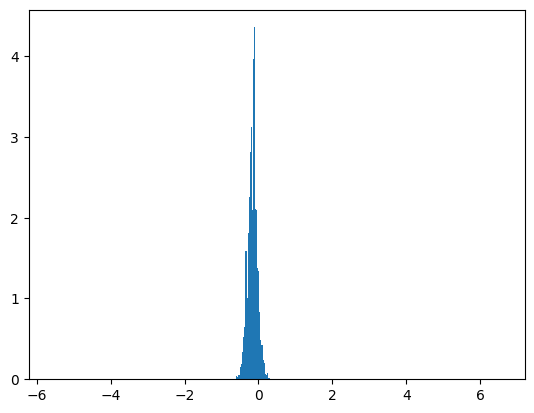

In [18]:
idx = 10
probs_of_first_pred = logits[batch_index, order_test_x[idx]].softmax(-1).detach().cpu().numpy()

borders = bucket_limits.cpu()
widths = borders[1:] - borders[:-1]

density_of_first_pred = probs_of_first_pred / widths

plt.bar(borders[:-1].tolist(), density_of_first_pred.tolist(), width=widths, align='edge')